In [1]:
import os
import gc
import sys
import argparse
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import utils, transforms, datasets
from torchvision.models.detection.rpn import AnchorGenerator

from transforms import ToTensor, Resize, Compose, testTensor, RandomVerticalFlip, RandomHorizontalFlip, Rotation
from data.kitti_dataset import KITTI
from data.voc import VOC
from backbone.backbone_vgg import vgg16, vgg11, vgg13, vgg19
from backbone.backbone_resnet import resnet18, resnet34
from models.faster_rcnn_mod import FasterRCNN
from models.mask_rcnn_mod import MaskRCNN
from models.keypoint_rcnn_mod import KeypointRCNN
from models.retinanet_mod import RetinaNet
from matplotlib.patches import Rectangle

from ID.intrinsic_dimension import estimate, block_analysis
from scipy.spatial.distance import pdist,squareform

from tqdm import tqdm
from PIL import Image

In [2]:
backbone = vgg16(pretrained=False).features
backbone.out_channels = 512
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5,1.0,2.0),)) 
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

In [3]:
root = os.getcwd()
model_path = os.path.join(root, "trained_model", "kitti", "faster_rcnn", "vgg16")

In [4]:
model = FasterRCNN(backbone, num_classes=10,rpn_anchor_generator= anchor_generator, box_roi_pool=roi_pooler )
model.load_state_dict(torch.load(os.path.join(model_path, 'model.pt'), map_location=torch.device('cpu')))

<All keys matched successfully>

In [5]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(in

In [6]:
def transform(width, height):
    transform = []
    transform.append(Resize((height, width)))
    transform.append(ToTensor())    
    #transform.append(RandomHorizontalFlip(1))
    transform.append(Rotation(1))
    transform = Compose(transform)
    return transform

In [7]:

def draw_box(box, label, score=''):
    x1, y1, x2, y2 = box
    color = plt.cm.get_cmap('tab10')(label)
    rect = Rectangle((x1,y1),x2-x1,y2-y1,linewidth=2,
                     edgecolor='k',
                     facecolor=color,alpha=0.5)
    plt.gca().add_patch(rect)
    

def plot_img(image, target=None, thld=0.5):
    image = image.permute(1,2,0).numpy()
    plt.imshow(image)
    if target:
        for i in range(len(target['labels'])):
            scores = target.get('scores')
            if scores is not None:
                if scores[i]<thld:
                    continue
                draw_box(target['boxes'][i], int(target['labels'][i]), str(float(scores[i]))[:4])
            else:
                draw_box(target['boxes'][i], int(target['labels'][i]))

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

root = 'D:/Dataset/KITTI'
num_classes = 10
width, height = 1200, 1200
transform = transform(width, height)
data = KITTI(root,transform)
indices = torch.randperm(len(data)).tolist()
#dataset = torch.utils.data.Subset(data, indices[:5500])
testdata = torch.utils.data.Subset(data, indices[5500:])
#traindata = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(testdata, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [9]:
root = 'D:/Dataset/VOCdevkit/VOC2012'
num_classes = 20
width, height = 600, 600
transform = transform(width, height)
data = VOC(root, transform)
indices = torch.randperm(len(data)).tolist()
#dataset = torch.utils.data.Subset(data, indices[:13500])
testdata = torch.utils.data.Subset(data, indices[13500:])
#traindata = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(testdata, batch_size=8, shuffle=True, collate_fn=collate_fn)

{'boxes': tensor([[ 62.2463,  87.8311, 658.3505, 624.5073],
        [320.3640, 130.5952, 546.4134, 457.4210]]), 'labels': tensor([12, 14]), 'image_id': tensor([100]), 'area': tensor([110275.,  23640.]), 'iscrowd': tensor([0, 0])}


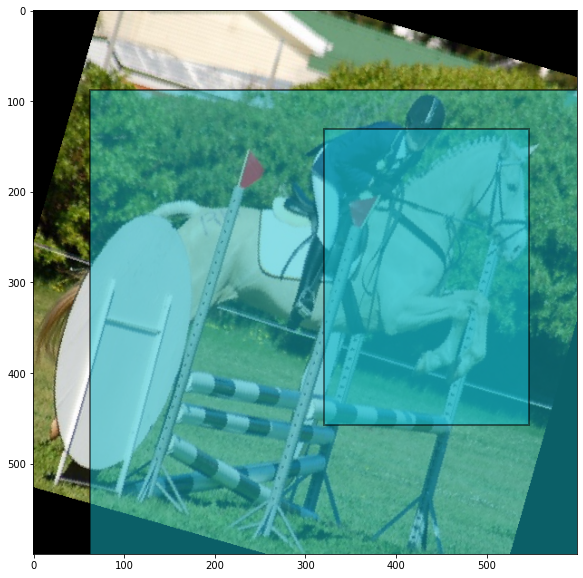

In [11]:
img, trgt = data[100]
print(trgt)
plt.figure(figsize=(10,10))
plot_img(img, trgt)